<a href="https://colab.research.google.com/github/AilingLiu/dimension_reduction_in_sklearn/blob/master/dimension_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There are few ways to implement dimension reduction.

1. using principle components to select d components that maximize variances of dataset
2. using kernelpca to transform features into different distribution (rbf, sigmoid)
3. using kmeans to reduce the dimensions into k clusters.

# Set up

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
# build a 3D dataset
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [0]:
# first centered the dataset, then get the Vt matrix that contains unit component
# after that, multiply the original X matrix to get the principle component matrix at desied d dimension
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0] #first component unit
c2 = Vt.T[:, 1] # secon component unit
X2d = X_centered.dot(Vt.T[:, :2])

# PCA using sklearn

pca in sklearn has done the centered process.

In [0]:

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X2d_sk = pca.fit_transform(X)

We can check the variance of transformed space.

In [54]:
pca.explained_variance_

array([0.77830975, 0.1351726 ])

In [55]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [56]:
1- pca.explained_variance_ratio_.sum()

0.011195535570688975

The first component explains 78% of the dataset variance's and the second component explains 13.5%. This leaves less than 1.1% of varance remains in other components.

In [58]:
np.allclose(X2d, -X2d_sk)

True

We can define the best number of components by few methods:

1. directly set the minimum variances you need
2. check the accumulated variances plot and choose 

In [17]:
# or set the n_components from 0 to 1
pca = PCA(n_components=0.95)
pca.fit(X)
np.cumsum(pca.explained_variance_ratio_)[-1]

0.988804464429311

In [0]:
# using plot

from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)


In [0]:
X, y = mnist['data'], mnist['target']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
X_train.shape

(56000, 784)

In [66]:
pca_img = PCA()
pca_img.fit(X_train)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Saving figure accumulated_explained_variance_of_dimensions


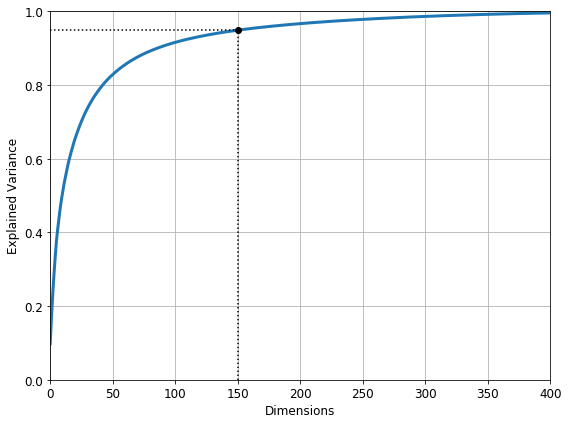

In [77]:
cumsum = np.cumsum(pca_img.explained_variance_ratio_)
plt.figure(figsize=(8, 6))
plt.plot(cumsum, linewidth=3)
plt.grid(True)
plt.xlabel('Dimensions', fontsize=12)
plt.ylabel('Explained Variance', fontsize=12)
plt.plot([150, 150], [0, cumsum[150]], 'k:')
plt.plot([0, 150], [cumsum[150], cumsum[150]], 'k:')
plt.axis([0, 400, 0, 1])
plt.plot(150, cumsum[150], 'ko')
save_fig('accumulated_explained_variance_of_dimensions')

In [0]:
# inverse back to original
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

# KernelPCA

In [0]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [81]:
X.shape

(1000, 3)

In [83]:
t.shape

(1000,)

In [0]:
y = (t > 6.9).astype(np.int)

In [87]:
from sklearn.decomposition import KernelPCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

ker_pca = Pipeline([
                    ('pca', KernelPCA(n_components=2)),
                    ('clf', LogisticRegression(solver="lbfgs"))
])

param_grid = [{
    'pca__kernel': ['rbf', 'sigmoid'],
    'pca__gamma':np.linspace(0.3, 0.5, 10)
}]

grid_ker_pca = GridSearchCV(ker_pca, param_grid=param_grid, cv=3)
grid_ker_pca.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('clf',
                      

In [88]:
grid_ker_pca.best_params_

{'pca__gamma': 0.3, 'pca__kernel': 'rbf'}

In [91]:
# we can use the best parameters to transforme the dataset, and inverse transform to check its reconstruciton errors with the original dataset

kpca_rbf = KernelPCA(n_components=2, kernel='rbf', gamma=0.3, fit_inverse_transform=True)
X_reduced = kpca_rbf.fit_transform(X)
X_recovered = kpca_rbf.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_recovered)

41.163286391709306

# Other methods

In [0]:
# t-sne

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_transformed = tsne.fit_transform(X)

In [0]:
# isomap

from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [97]:
# lda
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Saving figure tsne_isomap_dimension_reduction
Saving figure tsne_isomap_dimension_reduction


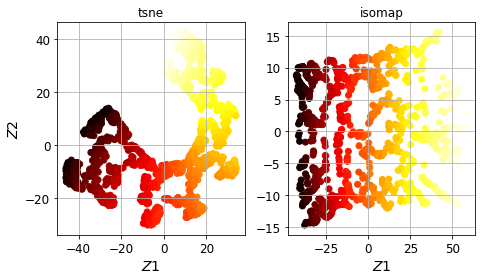

In [105]:
titles = ['tsne', 'isomap']
plt.figure(figsize=(10, 4))

for subplot, title, X_reduced in zip((131, 132), titles, (X_transformed, X_reduced_isomap)):
  plt.subplot(subplot)
  plt.title(title)
  plt.xlabel('$Z1$')
  plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
  if subplot==131:
    plt.ylabel('$Z2$')
  plt.grid()

  save_fig('tsne_isomap_dimension_reduction')